# Imports

In [1]:
#Data loading
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, f1_score
from IPython.display import clear_output

from joblib import load
from tqdm import trange
from tqdm.notebook import tqdm



from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold


# GNN Model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphConv, GATConv, GATv2Conv, SAGEConv
from tqdm import tqdm
import sys
import time

# Sparse vector
from Sparse_vector.sparse_vector import SparseVector

In [2]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Data loading

In [3]:
chrom_names = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y','M']]
features = [i[:-4] for i in os.listdir('z_dna/hg38_features/sparse/') if i.endswith('_2.pkl')]
groups = ['DNase-seq', 'Histone', 'RNA polymerase', 'TFs and others']
feature_names = [i for i in features]

In [4]:
def chrom_reader(chrom):
    files = sorted([i for i in os.listdir(f'z_dna/hg38_dna/') if f"{chrom}_" in i])
    return ''.join([load(f"z_dna/hg38_dna/{file}") for file in files])

In [ ]:
%%time
DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chrom_names)}
#ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_shin.pkl')
ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

#ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

DNA_features = {feature: load(f'z_dna/hg38_features/sparse/{feature}.pkl')
                for feature in tqdm(feature_names)}

  3%|██▏                                                                              | 52/1946 [00:01<00:50, 37.36it/s]

# Data selection 

In [ ]:
import numpy as np
from itertools import product

def generate_fix_n_subgroups(n):
    nucleotides = ['A', 'T', 'G', 'C']
    subgroups = []
    subgroups.extend([''.join(p) for p in product(nucleotides, repeat=n)])
    return subgroups

def generate_subgroups(n):
    nucleotides = ['A', 'T', 'G', 'C']
    subgroups = []
    for i in range(1, n + 1):
        subgroups.extend([''.join(p) for p in product(nucleotides, repeat=i)])
    return subgroups

def encode_sequence_as_features_ndarray(n_str: str, k_str: str):
    n = len(n_str)
    k = len(k_str)
    result = np.zeros(n, dtype=int)
    
    for i in range(n - k + 1):
        if n_str[i:i+k] == k_str:
            result[i:i+k] = 1
    
    return result.tolist()

In [ ]:
from torch.utils import data

class Dataset(data.Dataset):
    def __init__(self, chroms, features,
                 dna_source, features_source,
                 labels_source, intervals, k_mer=1, groups=['A','T','G','C'],
                 lrp_feat=[]):
        self.chroms = chroms
        self.features = features
        self.dna_source = dna_source
        self.features_source = features_source
        self.labels_source = labels_source
        self.intervals = intervals
        
        self.k_mer = k_mer
        self.groups = groups
        
        self.lrp_feat = lrp_feat

    def __len__(self):
        return len(self.intervals)

    def __getitem__(self, index):
        interval = self.intervals[index]
        chrom = interval[0]
        begin = int(interval[1])
        end = int(interval[2])
        
        dna_OHE = []
        
        for group in self.groups:
            featuress = encode_sequence_as_features_ndarray(self.dna_source[chrom][begin:end].upper(), group)
            
            dna_OHE.append(featuress)
        
        dna_OHE = list(map(list, zip(*dna_OHE)))
        dna_OHE = np.array(dna_OHE)
        feature_matr = []
        
        if len(feature_matr) > 0:
            X = np.hstack((dna_OHE, np.array(feature_matr).T/1000)).astype(np.float32)
        else:
            X = dna_OHE.astype(np.float32)
            
        y = self.labels_source[interval[0]][interval[1]: interval[2]]
        if len(self.lrp_feat) > 0:
            X = X[:,np.sort(lrp_feat)]

        return (X, y)

In [ ]:
width = 100

np.random.seed(10)

ints_in = []
ints_out = []

for chrm in chrom_names:
    for st in trange(0, ZDNA[chrm].shape - width, width):
        interval = [st, min(st + width, ZDNA[chrm].shape)]
        if ZDNA[chrm][interval[0]: interval[1]].any():
            ints_in.append([chrm, interval[0], interval[1]])
        else:
            ints_out.append([chrm, interval[0], interval[1]])

ints_in = np.array(ints_in)
ints_out = np.array(ints_out)[np.random.choice(range(len(ints_out)), size=len(ints_in) * 2, replace=False)]

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
np.random.seed(42)
equalized = np.vstack((ints_in, ints_out))
equalized = [[inter[0], int(inter[1]), int(inter[2])] for inter in equalized]

labels = np.array([1]*len(ints_in) + [0]*len(ints_out))
chromes = [inter[0] for inter in equalized]
strat_labels = np.array([f"{label}_{chrom}" for label, chrom in zip(labels, chromes)])
print(strat_labels)
  
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_inds, test_inds = next(sss.split(equalized, strat_labels))
  
train_intervals, test_intervals = [equalized[i] for i in train_inds], [equalized[i] for i in test_inds]

In [ ]:
params = {'batch_size':32,
          'num_workers':4,
          'shuffle':True}

max_k_mer_size = 4
groups = generate_subgroups(max_k_mer_size)

train_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, train_intervals, max_k_mer_size, groups, lrp_feat = [])

test_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, test_intervals, max_k_mer_size, groups, lrp_feat = [])

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)

# All models

In [ ]:
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, recall_score
from IPython.display import clear_output

In [ ]:
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, f1_score
from IPython.display import clear_output

class DeepCNNSiLU_9L(nn.Module):
    def __init__(self, top_count):
        super().__init__()
        
        self.num_f = top_count
        self.seq = nn.Sequential(
            
            nn.Conv2d(1, 3, kernel_size=(3, 3), padding=1),
            nn.LayerNorm([3, 100, top_count]),
            nn.SiLU(),
            
            nn.Conv2d(3, 5, kernel_size=(5, 5), padding=2),
            nn.LayerNorm([5, 100, top_count]),
            nn.SiLU(),
            
            nn.Conv2d(5, 7, kernel_size=(5, 5), padding=2),
            nn.LayerNorm([7, 100, top_count]),
            nn.SiLU(),
            
            nn.Conv2d(7, 9, kernel_size=(5, 5), padding=2),
            nn.LayerNorm([9, 100, top_count]),
            nn.SiLU(),
            
            nn.Conv2d(9, 9, kernel_size=(5, 5), padding=2),
            nn.SiLU(),
            
            nn.Conv2d(9, 7, kernel_size=(5, 5), padding=2),
            nn.LayerNorm([7, 100, top_count]),
            nn.SiLU(),
            
            nn.Conv2d(7, 5, kernel_size=(5, 5), padding=2),
            nn.LayerNorm([5, 100, top_count]),
            nn.SiLU(),
            
            nn.Conv2d(5, 3, kernel_size=(5, 5), padding=2),
            nn.LayerNorm([3, 100, top_count]),
            nn.SiLU(),
            
            nn.Conv2d(3, 1, kernel_size=(3, 3), padding=1),
            nn.LayerNorm([1, 100, top_count]),  # Укажите размеры после свертки
            nn.SiLU(),
            
            nn.Linear(top_count, 500),
            nn.SiLU(),
            
            nn.Linear(500, 2)
        )

    def forward(self, x):
        batch = x.shape[0]
        x = x.reshape(batch, 1, width, self.num_f)
        x = self.seq(x)
        x = torch.squeeze(x)
        x = F.log_softmax(x, dim=-1)
        return x

# Train and test

In [ ]:
import time
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

def loss_func(output, y_batch):
    return torch.nn.NLLLoss()(output, y_batch)


def train_epoch(model, optimizer, loader_train):
    roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log = [], [], [], [], [], []
    model.train()
    for X_batch, y_batch in tqdm(loader_train, desc='Train') :
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda().long()
        optimizer.zero_grad()
        
        output = model(X_batch)
        
        pred = torch.argmax(output, dim=-1)
        y_pred = nn.Softmax(dim=-1)(output)[..., 1].detach().cpu().numpy().flatten()
        
        if np.std(y_batch.cpu().numpy().flatten()) == 0:
            roc_auc = 0
            precision = 0
            recall = 0
        else:
            roc_auc = roc_auc_score(y_batch.cpu().numpy().flatten(),
                                    y_pred)
            precision = precision_score(y_batch.cpu().numpy().flatten(), pred.cpu().numpy().flatten())
            recall = recall_score(y_batch.cpu().numpy().flatten(), pred.cpu().numpy().flatten())
        
        
        roc_auc_log.append(roc_auc)
        precision_log.append(precision)
        recall_log.append(recall)
        
        
        f1_log.append(f1_score(y_batch.cpu().numpy().flatten(),
                         pred.cpu().numpy().flatten()))

        acc = torch.mean((pred == y_batch).float())
        acc_log.append(acc.cpu().numpy())
        
        loss = loss_func(output.permute([0, 2, 1]), y_batch)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
        
    return roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log

def test(model, loader_test):
    roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log = [], [], [], [], [], []
    model.eval()
    means = []
    for X_batch, y_batch in tqdm(loader_test, desc='Test'):
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda().long()
        output = model(X_batch)
        means.append(y_batch.sum().cpu() / (1.0 * y_batch.shape[0]))
        
        pred = torch.argmax(output, dim=-1)
        y_pred = nn.Softmax(dim=-1)(output)[..., 1].detach().cpu().numpy().flatten()
        
        if np.std(y_batch.cpu().numpy().flatten()) == 0:
            roc_auc = 0
            precision = 0
            recall = 0
        else:
            roc_auc = roc_auc_score(y_batch.cpu().numpy().flatten(),
                                    y_pred)
            precision = precision_score(y_batch.cpu().numpy().flatten(), pred.cpu().numpy().flatten())
            recall = recall_score(y_batch.cpu().numpy().flatten(), pred.cpu().numpy().flatten())
        
        
        roc_auc_log.append(roc_auc)
        precision_log.append(precision)
        recall_log.append(recall)
        
        f1 = f1_score(y_batch.cpu().numpy().flatten(),
                                  pred.cpu().numpy().flatten())
        
        f1_log.append(f1)
        
        acc = torch.mean((pred == y_batch).float())
        acc_log.append(acc.cpu().numpy())
        
        if output.dim() == 2:  
            output = output.unsqueeze(0)
        loss = loss_func(output.permute([0, 2, 1]), y_batch)
        loss = loss.item()
        loss_log.append(loss)
        
    return roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log

def plot_history(train_history, valid_history, title, BatchSize, epoch_to_show=20):
    plt.figure(figsize=(epoch_to_show, 4))
    plt.title(title)    
    
    epoch_num = len(valid_history)
    train_history = np.array([None] * (BatchSize * epoch_to_show) + train_history)
    valid_history = np.array([None] * epoch_to_show + valid_history)
    
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, (epoch_to_show+1)*BatchSize), 
             train_history[-(epoch_to_show+1)*BatchSize:], c='red', label='train')
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, epoch_to_show+1),
                valid_history[-epoch_to_show-1:], c='green', label='test')
    
    plt.ylim((0, 1))
    plt.yticks(np.linspace(0, 1, 11))
    plt.xticks(np.arange(epoch_num-epoch_to_show+1, epoch_num+2), 
              np.arange(epoch_num-epoch_to_show, epoch_num+1).astype(int))
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs, loader_train, loader_test):
    train_auc_log, train_pr_log, train_rec_log, train_f1_log, train_acc_log, train_loss_log = [], [], [], [], [], []
    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log = [], [], [], [], [], []
    times = []
    
    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch + 1, n_epochs))
        
        start_time = time.time()
        
        train_auc, train_pr, train_rec, train_f1, train_acc, train_loss = train_epoch(model, opt, loader_train)
        val_auc, val_pr, val_rec, val_f1, val_acc, val_loss = test(model, loader_test)
        
        end_time = time.time()
        t = end_time - start_time
        times.append(t)
        
        BatchSize = len(train_loss)
        
        train_auc_log.extend(train_auc)
        train_pr_log.extend(train_pr)
        train_rec_log.extend(train_rec)
        train_f1_log.extend(train_f1)
        train_acc_log.extend(train_acc)
        train_loss_log.extend(train_loss)

        val_auc_log.append(np.mean(val_auc))
        val_pr_log.append(np.mean(val_pr))
        val_rec_log.append(np.mean(val_rec))
        val_f1_log.append(np.mean(val_f1))
        val_acc_log.append(np.mean(val_acc))
        val_loss_log.append(np.mean(val_loss))
        
#         raise BaseException
        clear_output()
        plot_history(train_loss_log, val_loss_log, 'Loss', len(train_loss), n_epochs)
        plot_history(train_auc_log, val_auc_log, 'Auc', len(train_loss), n_epochs)
        plot_history(train_pr_log, val_pr_log, 'Precision', len(train_loss), n_epochs)
        plot_history(train_rec_log, val_rec_log, 'Recall', len(train_loss), n_epochs)
        plot_history(train_f1_log, val_f1_log, 'F1', len(train_loss), n_epochs)
        print("Time: ", t/60)
        print("Epoch {}: ROC-AUC = {:.2%}".format(epoch+1, val_auc_log[-1]))
        print("Epoch {}: Precision = {:.3}".format(epoch+1, val_pr_log[-1]))
        print("Epoch {}: Recall = {:.3}".format(epoch+1, val_rec_log[-1]))
        print("Epoch {}: F1-score = {:.3}".format(epoch+1, val_f1_log[-1]))
            
           
    print("Final ROC-AUC = {:.4}".format(val_auc_log[-1]))
    print("Final Precision = {:.3}".format(val_pr_log[-1]))
    print("Final Recall = {:.3}".format(val_rec_log[-1]))
    print("Final F1-score = {:.3}".format(val_f1_log[-1]))
    return val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times    

# Запуск 1-меры

In [14]:
params = {'batch_size':32,
          'num_workers':4,
          'shuffle':True}

max_k_mer_size = 1
groups = generate_fix_n_subgroups(max_k_mer_size)

train_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, train_intervals, max_k_mer_size, groups, lrp_feat = [])

test_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, test_intervals, max_k_mer_size, groups, lrp_feat = [])

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)

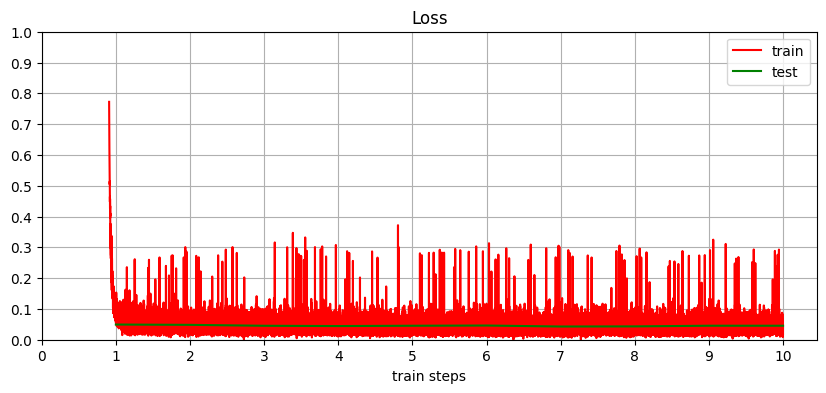

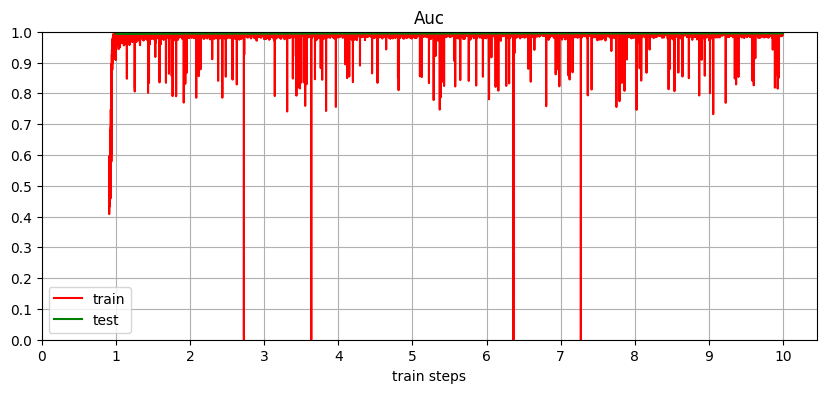

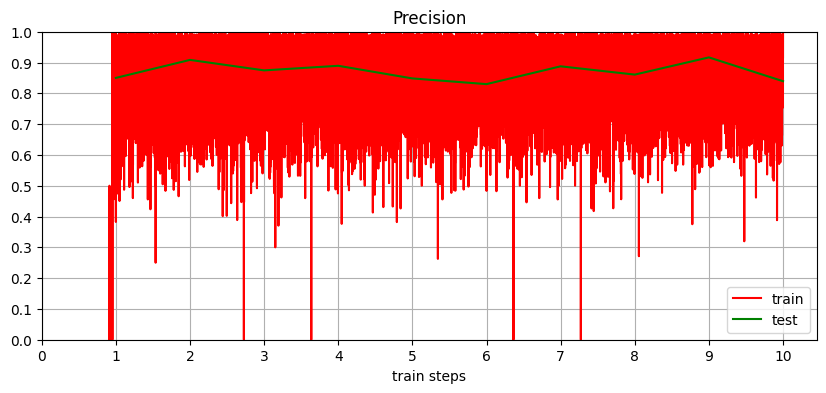

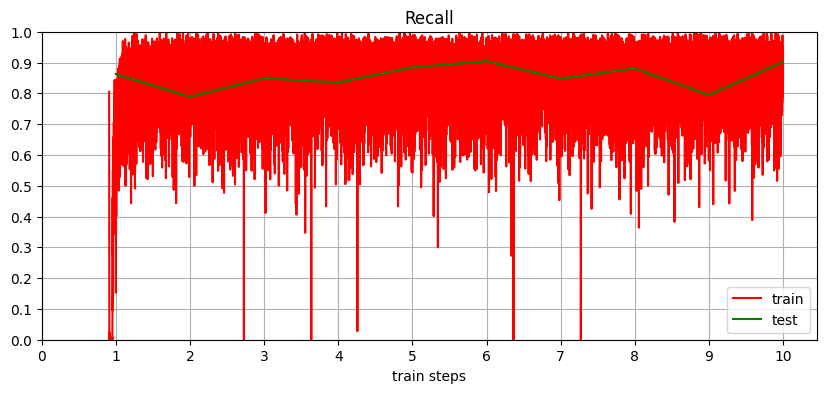

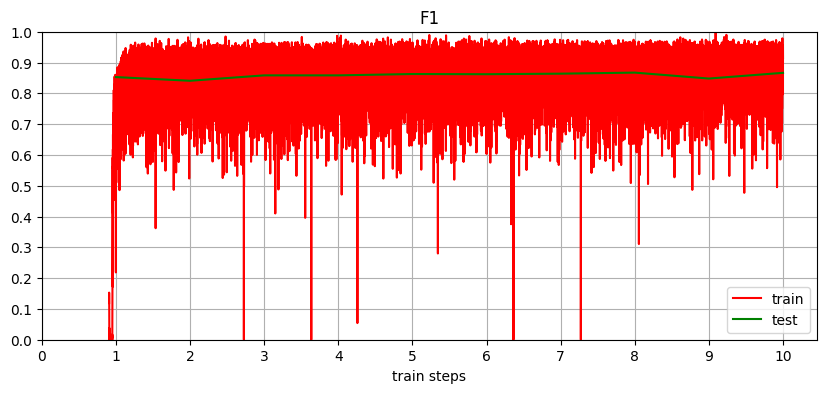

Time:  1.446868367989858
Epoch 10: ROC-AUC = 99.47%
Epoch 10: Precision = 0.839
Epoch 10: Recall = 0.902
Epoch 10: F1-score = 0.867
Final ROC-AUC = 0.9947
Final Precision = 0.839
Final Recall = 0.902
Final F1-score = 0.867
CPU times: user 14min 6s, sys: 57.1 s, total: 15min 3s
Wall time: 14min 46s


In [15]:
%%time

feature_count = len(groups)
device = torch.device(f'cuda:{1}')
with torch.cuda.device(device):
    set_random_seed(42)
    model = DeepCNNSiLU_9L(feature_count)
    model = model.to('cuda')

    opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 10, loader_train, loader_test)
    

In [16]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}".format(val_f1_log[np.argmax(val_f1_log)]))
print("ROC-AUC: {:.4f}".format(val_auc_log[np.argmax(val_f1_log)]))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 8
Max F1-score: 0.8672
ROC-AUC: 0.9946
Precision: 0.8608
Recall: 0.8810
Mean time for 1 epoch 1.46 minutes


# Запуск 2-меры

In [17]:
params = {'batch_size':32,
          'num_workers':4,
          'shuffle':True}

max_k_mer_size = 2
groups = generate_fix_n_subgroups(max_k_mer_size)

train_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, train_intervals, max_k_mer_size, groups, lrp_feat = [])

test_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, test_intervals, max_k_mer_size, groups, lrp_feat = [])

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)

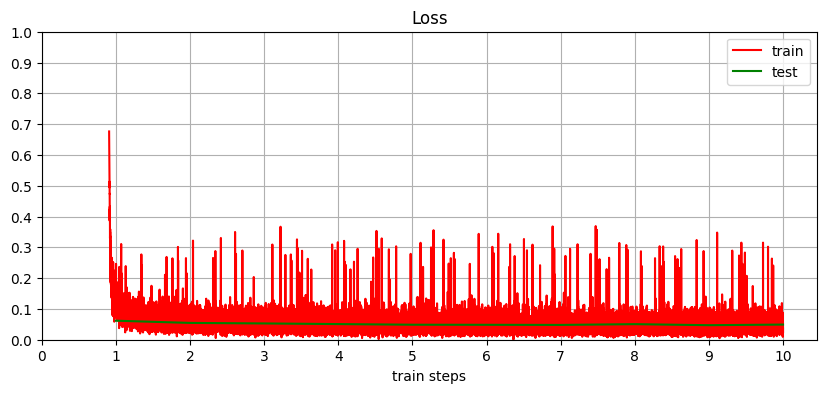

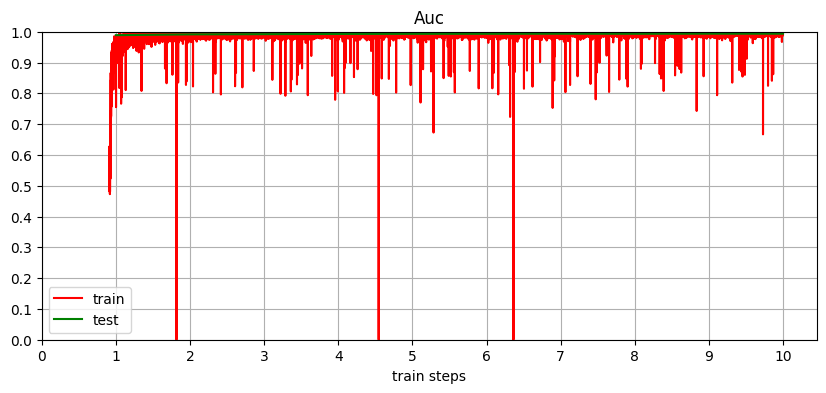

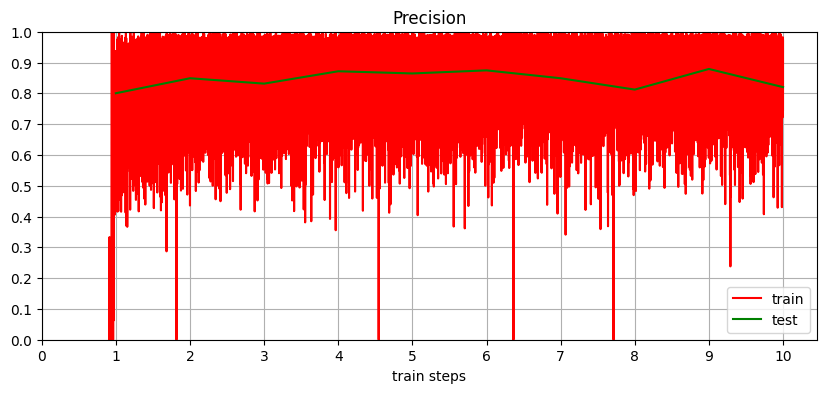

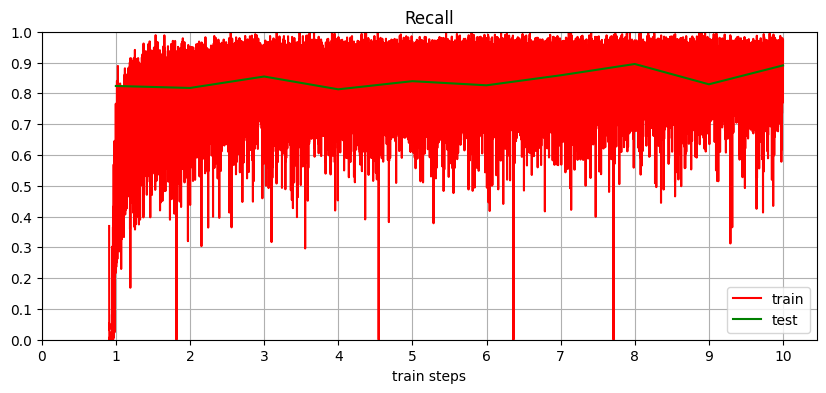

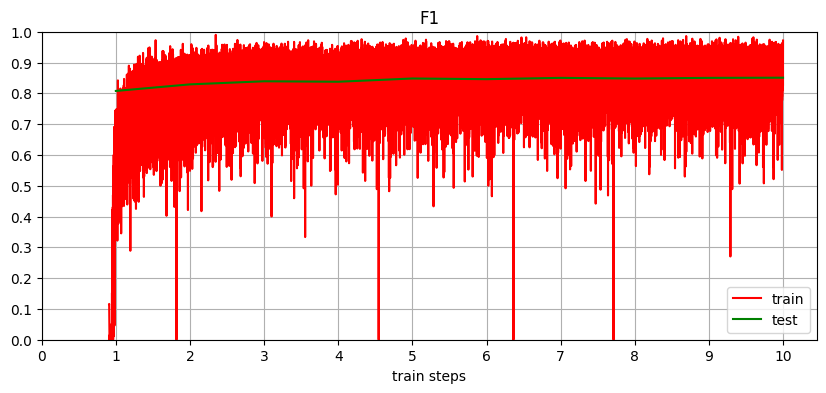

Time:  1.571845829486847
Epoch 10: ROC-AUC = 99.36%
Epoch 10: Precision = 0.82
Epoch 10: Recall = 0.891
Epoch 10: F1-score = 0.851
Final ROC-AUC = 0.9936
Final Precision = 0.82
Final Recall = 0.891
Final F1-score = 0.851
CPU times: user 15min 3s, sys: 1min 12s, total: 16min 15s
Wall time: 15min 57s


In [18]:
%%time

feature_count = len(groups)
device = torch.device(f'cuda:{1}')
with torch.cuda.device(device):
    set_random_seed(42)
    model = DeepCNNSiLU_9L(feature_count)
    model = model.to('cuda')

    opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 10, loader_train, loader_test)
    

In [19]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}".format(val_f1_log[np.argmax(val_f1_log)]))
print("ROC-AUC: {:.4f}".format(val_auc_log[np.argmax(val_f1_log)]))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 10
Max F1-score: 0.8507
ROC-AUC: 0.9936
Precision: 0.8201
Recall: 0.8906
Mean time for 1 epoch 1.57 minutes


# Запуск 3-меры

In [20]:
params = {'batch_size':32,
          'num_workers':4,
          'shuffle':True}

max_k_mer_size = 3
groups = generate_fix_n_subgroups(max_k_mer_size)

train_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, train_intervals, max_k_mer_size, groups, lrp_feat = [])

test_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, test_intervals, max_k_mer_size, groups, lrp_feat = [])

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)

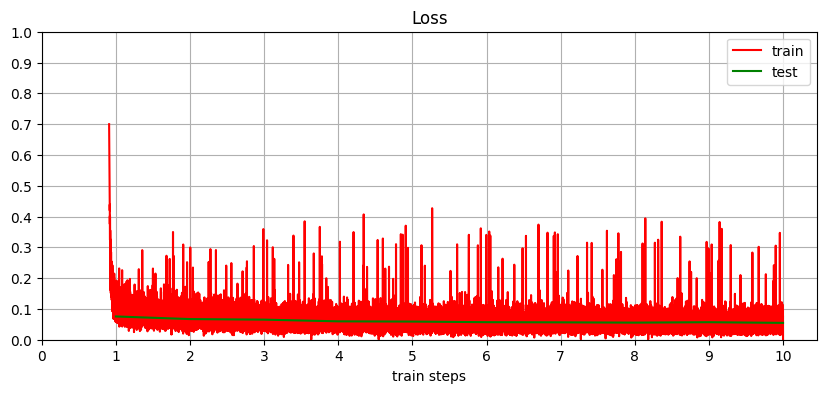

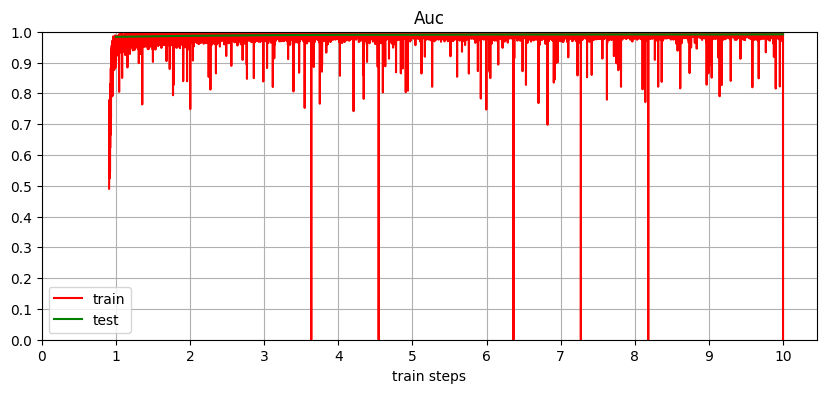

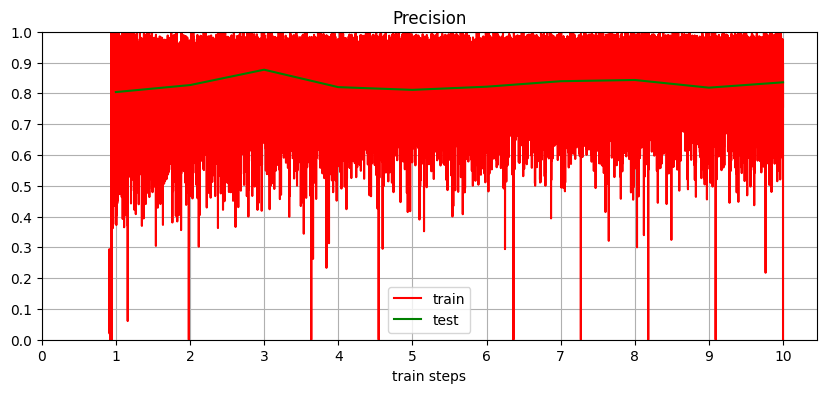

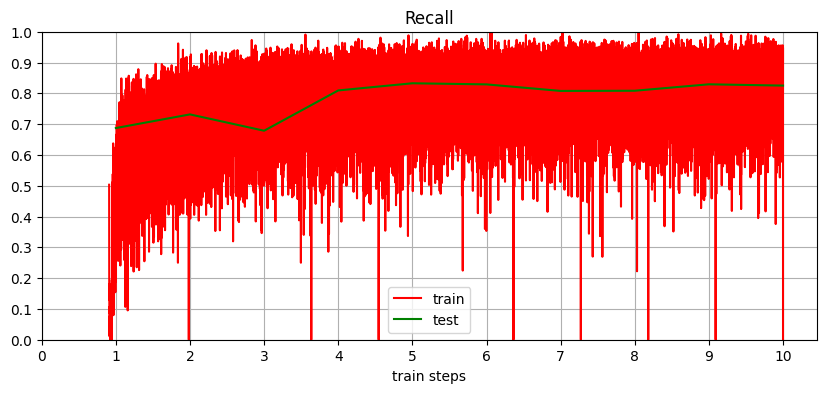

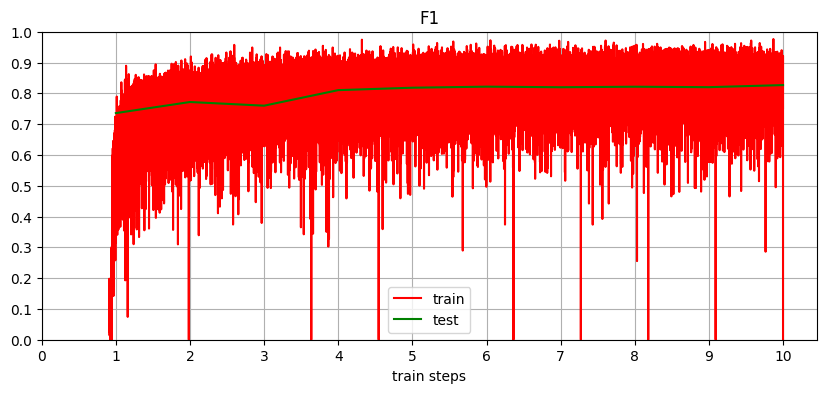

Time:  2.81755979458491
Epoch 10: ROC-AUC = 99.15%
Epoch 10: Precision = 0.836
Epoch 10: Recall = 0.825
Epoch 10: F1-score = 0.827
Final ROC-AUC = 0.9915
Final Precision = 0.836
Final Recall = 0.825
Final F1-score = 0.827
CPU times: user 23min 48s, sys: 4min 9s, total: 27min 58s
Wall time: 27min 54s


In [21]:
%%time

feature_count = len(groups)
device = torch.device(f'cuda:{1}')
with torch.cuda.device(device):
    set_random_seed(42)
    model = DeepCNNSiLU_9L(feature_count)
    model = model.to('cuda')

    opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 10, loader_train, loader_test)
    

In [22]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}".format(val_f1_log[np.argmax(val_f1_log)]))
print("ROC-AUC: {:.4f}".format(val_auc_log[np.argmax(val_f1_log)]))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 10
Max F1-score: 0.8268
ROC-AUC: 0.9915
Precision: 0.8358
Recall: 0.8251
Mean time for 1 epoch 2.77 minutes


# Запуск 4-меры

In [23]:
params = {'batch_size':32,
          'num_workers':4,
          'shuffle':True}

max_k_mer_size = 4
groups = generate_fix_n_subgroups(max_k_mer_size)

train_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, train_intervals, max_k_mer_size, groups, lrp_feat = [])

test_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, test_intervals, max_k_mer_size, groups, lrp_feat = [])

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)

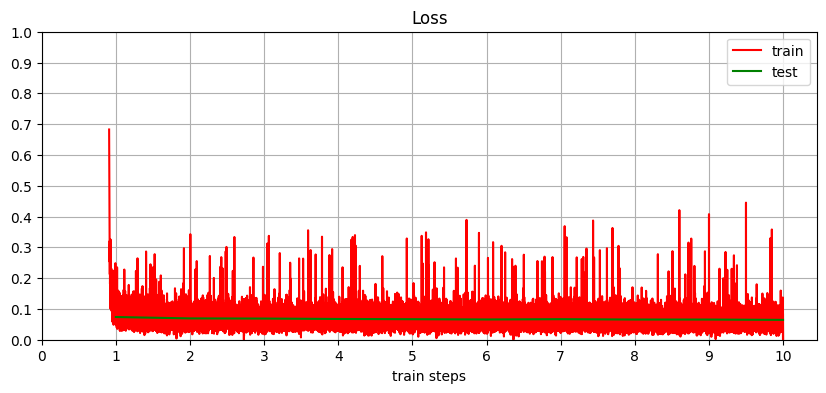

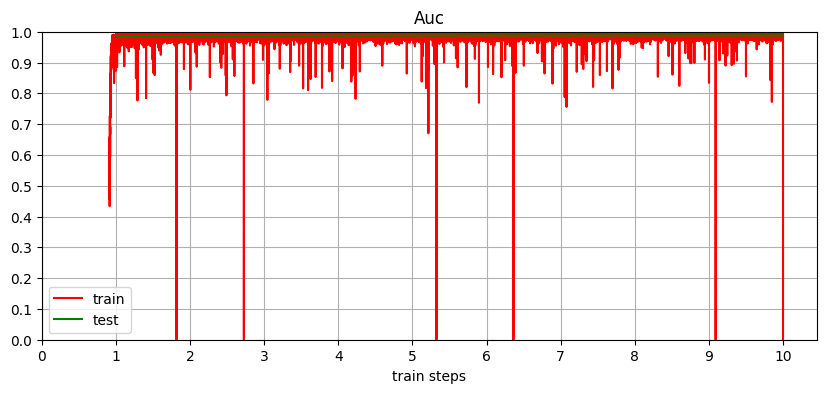

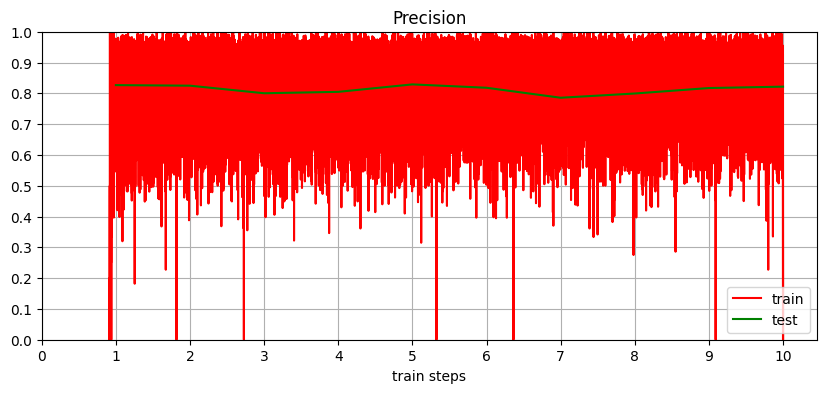

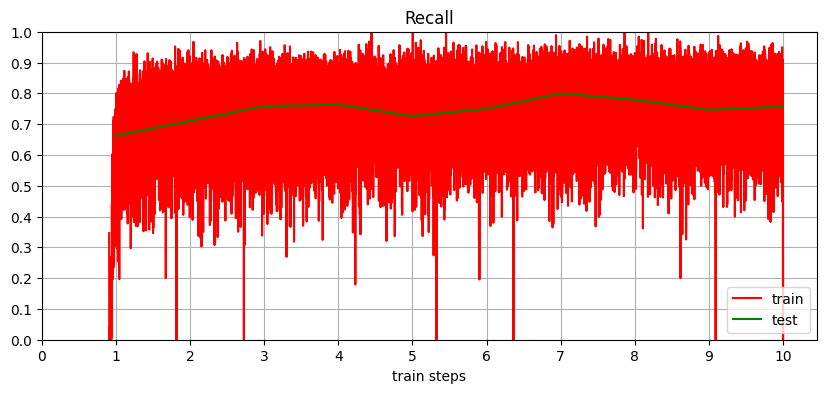

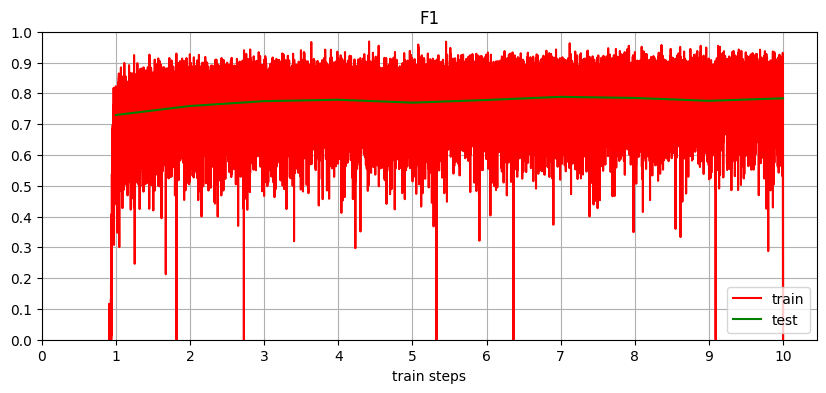

Time:  6.416070659955342
Epoch 10: ROC-AUC = 98.79%
Epoch 10: Precision = 0.822
Epoch 10: Recall = 0.757
Epoch 10: F1-score = 0.784
Final ROC-AUC = 0.9879
Final Precision = 0.822
Final Recall = 0.757
Final F1-score = 0.784
CPU times: user 49min 44s, sys: 12min 51s, total: 1h 2min 35s
Wall time: 1h 4min 27s


In [24]:
%%time

feature_count = len(groups)
device = torch.device(f'cuda:{1}')
with torch.cuda.device(device):
    set_random_seed(42)
    model = DeepCNNSiLU_9L(feature_count)
    model = model.to('cuda')

    opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 10, loader_train, loader_test)
    

In [25]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}".format(val_f1_log[np.argmax(val_f1_log)]))
print("ROC-AUC: {:.4f}".format(val_auc_log[np.argmax(val_f1_log)]))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 7
Max F1-score: 0.7886
ROC-AUC: 0.9876
Precision: 0.7857
Recall: 0.7997
Mean time for 1 epoch 6.42 minutes


# Запуск 5-меры

In [26]:
params = {'batch_size':32,
          'num_workers':4,
          'shuffle':True}

max_k_mer_size = 5
groups = generate_fix_n_subgroups(max_k_mer_size)

train_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, train_intervals, max_k_mer_size, groups, lrp_feat = [])

test_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, test_intervals, max_k_mer_size, groups, lrp_feat = [])

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)

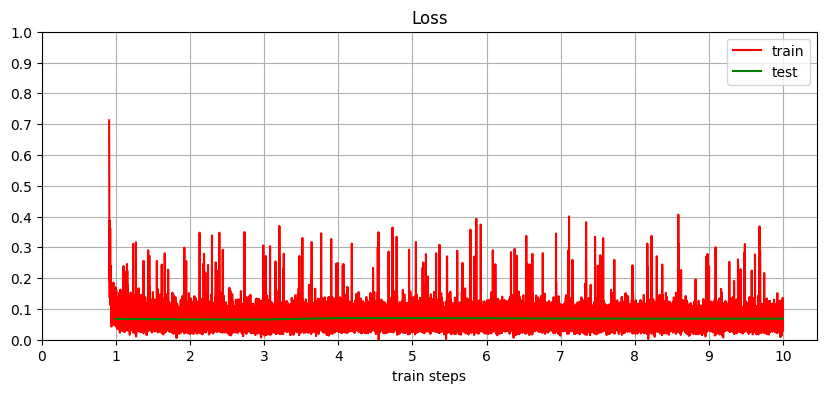

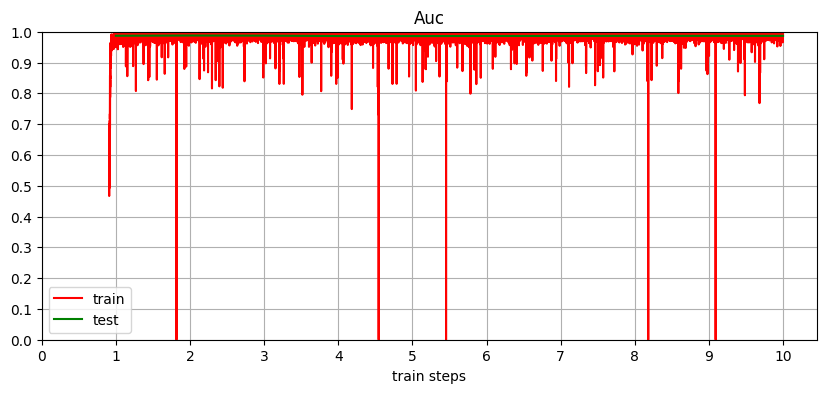

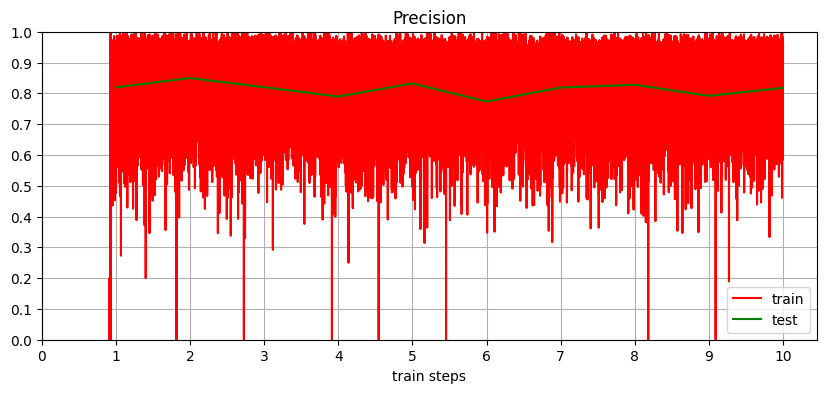

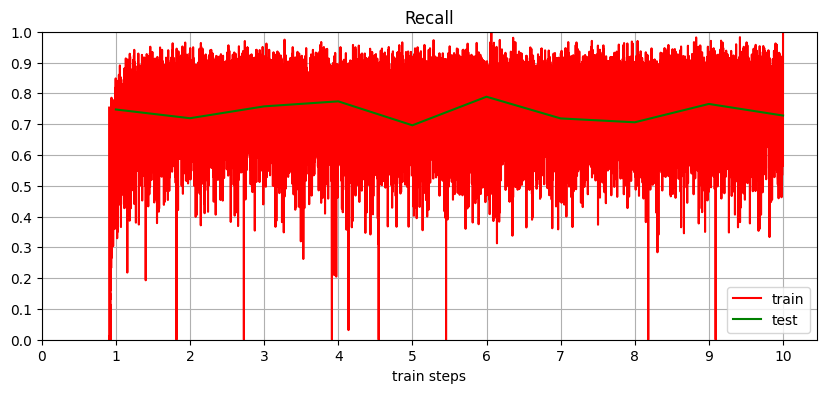

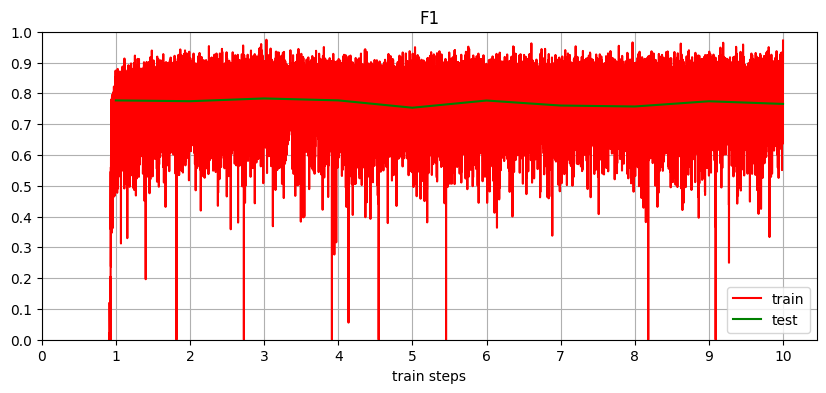

Time:  25.355771179993948
Epoch 10: ROC-AUC = 98.65%
Epoch 10: Precision = 0.818
Epoch 10: Recall = 0.728
Epoch 10: F1-score = 0.766
Final ROC-AUC = 0.9865
Final Precision = 0.818
Final Recall = 0.728
Final F1-score = 0.766
CPU times: user 3h 5min 37s, sys: 59min, total: 4h 4min 37s
Wall time: 4h 22min 15s


In [27]:
%%time

feature_count = len(groups)
device = torch.device(f'cuda:{1}')
with torch.cuda.device(device):
    set_random_seed(42)
    model = DeepCNNSiLU_9L(feature_count)
    model = model.to('cuda')

    opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 10, loader_train, loader_test)
    

In [28]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}".format(val_f1_log[np.argmax(val_f1_log)]))
print("ROC-AUC: {:.4f}".format(val_auc_log[np.argmax(val_f1_log)]))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 3
Max F1-score: 0.7834
ROC-AUC: 0.9873
Precision: 0.8201
Recall: 0.7576
Mean time for 1 epoch 26.20 minutes


# Запуск 1-2-меры

In [14]:
params = {'batch_size':32,
          'num_workers':4,
          'shuffle':True}

max_k_mer_size = 2
groups = generate_subgroups(max_k_mer_size)

train_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, train_intervals, max_k_mer_size, groups, lrp_feat = [])

test_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, test_intervals, max_k_mer_size, groups, lrp_feat = [])

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)

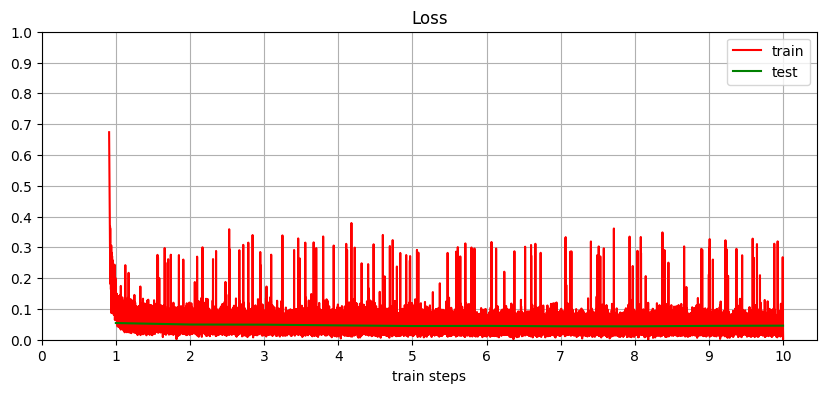

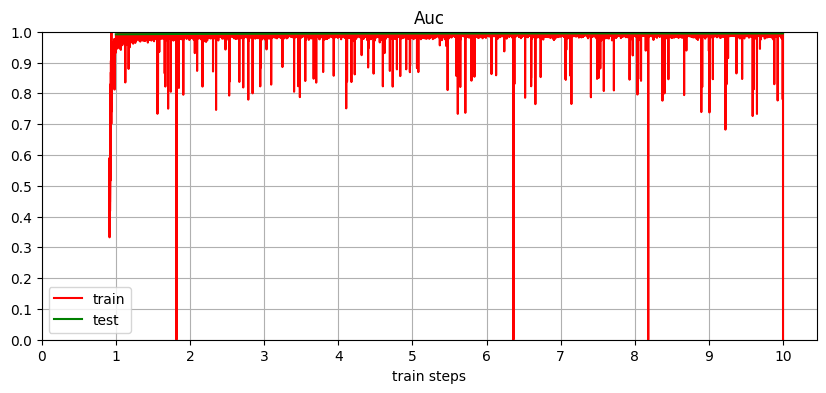

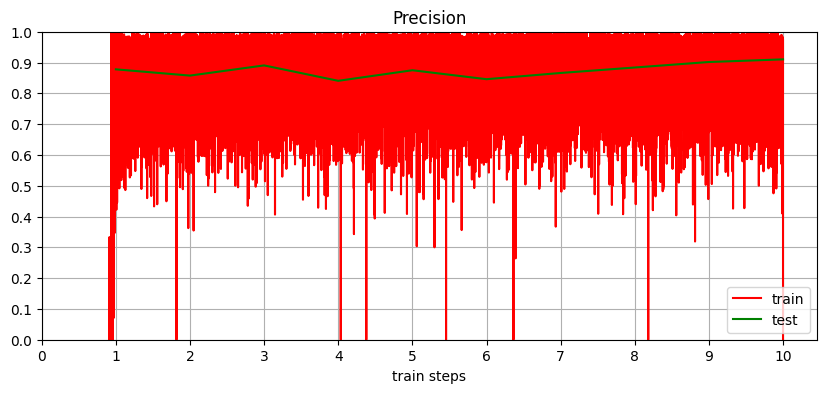

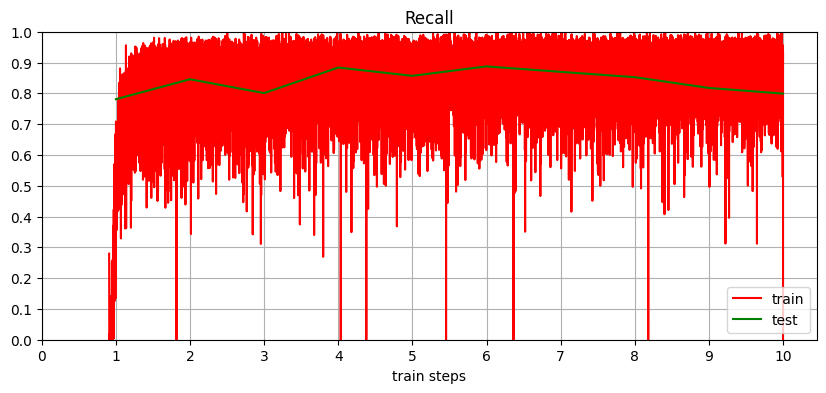

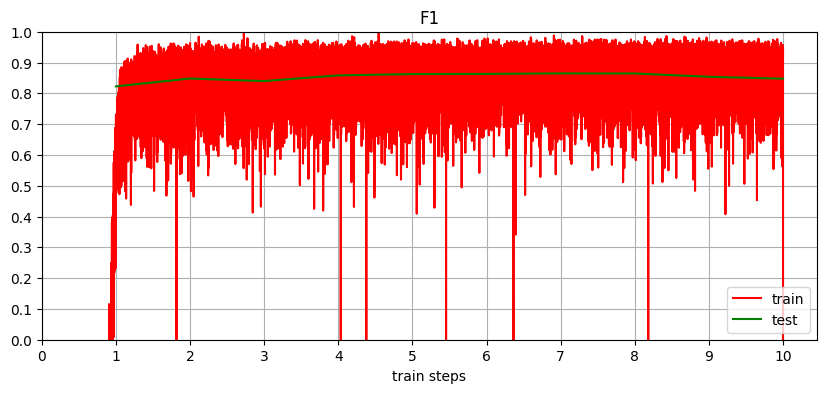

Time:  1.6908275326093039
Epoch 10: ROC-AUC = 99.46%
Epoch 10: Precision = 0.91
Epoch 10: Recall = 0.799
Epoch 10: F1-score = 0.847
Final ROC-AUC = 0.9946
Final Precision = 0.91
Final Recall = 0.799
Final F1-score = 0.847
CPU times: user 15min 56s, sys: 1min 28s, total: 17min 25s
Wall time: 17min 6s


In [15]:
%%time

feature_count = len(groups)
device = torch.device(f'cuda:{1}')
with torch.cuda.device(device):
    set_random_seed(42)
    model = DeepCNNSiLU_9L(feature_count)
    model = model.to('cuda')

    opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 10, loader_train, loader_test)
    

In [16]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}".format(val_f1_log[np.argmax(val_f1_log)]))
print("ROC-AUC: {:.4f}".format(val_auc_log[np.argmax(val_f1_log)]))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 7
Max F1-score: 0.8648
ROC-AUC: 0.9946
Precision: 0.8661
Recall: 0.8697
Mean time for 1 epoch 1.69 minutes


In [17]:
torch.save(model.state_dict(), 'DeepCNNSiLU_9L_1_2_k_mers.pt')

# Запуск 1-3-меры

In [18]:
params = {'batch_size':32,
          'num_workers':4,
          'shuffle':True}

max_k_mer_size = 3
groups = generate_subgroups(max_k_mer_size)

train_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, train_intervals, max_k_mer_size, groups, lrp_feat = [])

test_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, test_intervals, max_k_mer_size, groups, lrp_feat = [])

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)

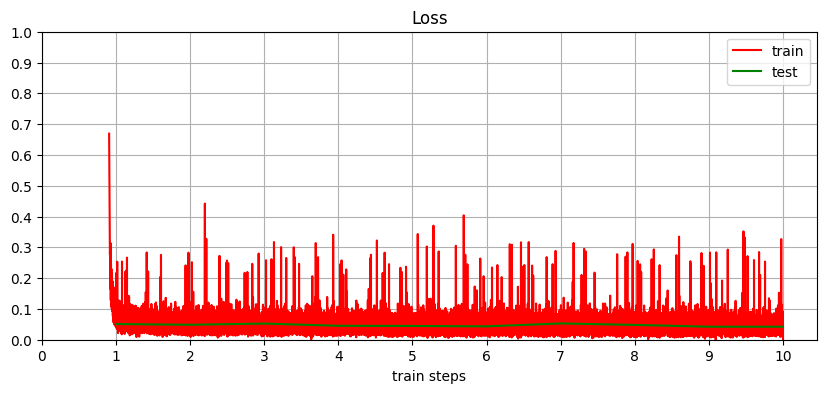

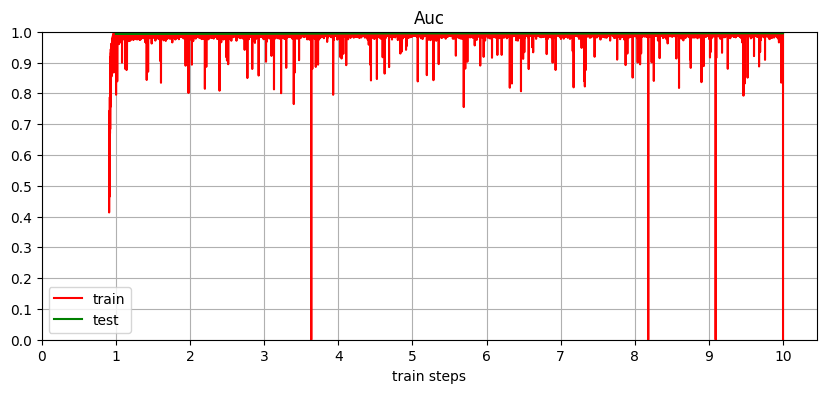

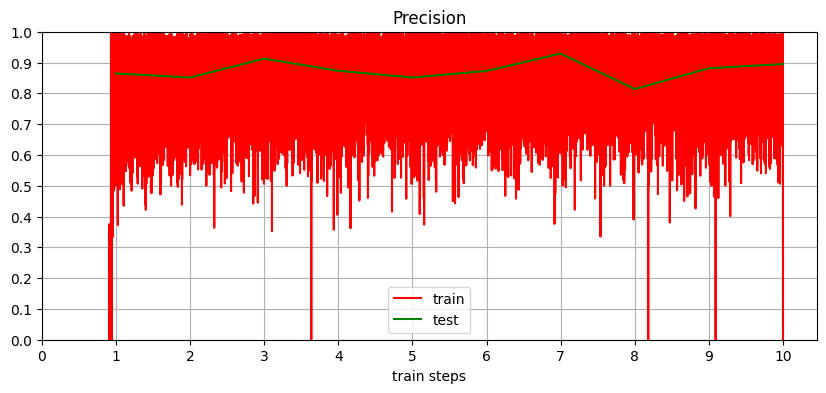

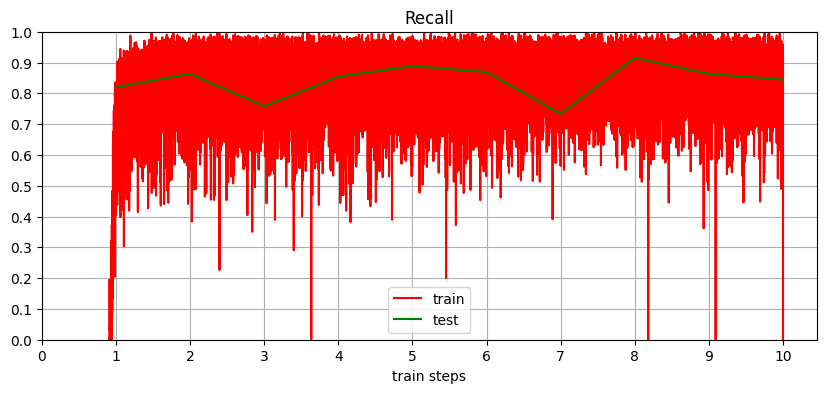

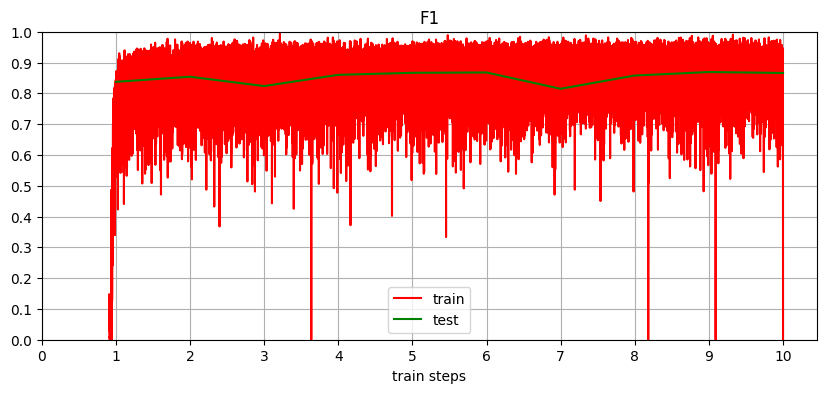

Time:  3.26290371020635
Epoch 10: ROC-AUC = 99.49%
Epoch 10: Precision = 0.895
Epoch 10: Recall = 0.845
Epoch 10: F1-score = 0.866
Final ROC-AUC = 0.9949
Final Precision = 0.895
Final Recall = 0.845
Final F1-score = 0.866
CPU times: user 27min 11s, sys: 5min 9s, total: 32min 20s
Wall time: 32min 47s


In [19]:
%%time

feature_count = len(groups)
device = torch.device(f'cuda:{1}')
with torch.cuda.device(device):
    set_random_seed(42)
    model = DeepCNNSiLU_9L(feature_count)
    model = model.to('cuda')

    opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 10, loader_train, loader_test)
    

In [20]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}".format(val_f1_log[np.argmax(val_f1_log)]))
print("ROC-AUC: {:.4f}".format(val_auc_log[np.argmax(val_f1_log)]))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 9
Max F1-score: 0.8691
ROC-AUC: 0.9950
Precision: 0.8814
Recall: 0.8632
Mean time for 1 epoch 3.26 minutes


In [21]:
torch.save(model.state_dict(), 'DeepCNNSiLU_9L_1_3_k_mers.pt')

# Запуск 1-4-меры

In [26]:
params = {'batch_size':32,
          'num_workers':4,
          'shuffle':True}

max_k_mer_size = 4
groups = generate_subgroups(max_k_mer_size)

train_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, train_intervals, max_k_mer_size, groups, lrp_feat = [])

test_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, test_intervals, max_k_mer_size, groups, lrp_feat = [])

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)

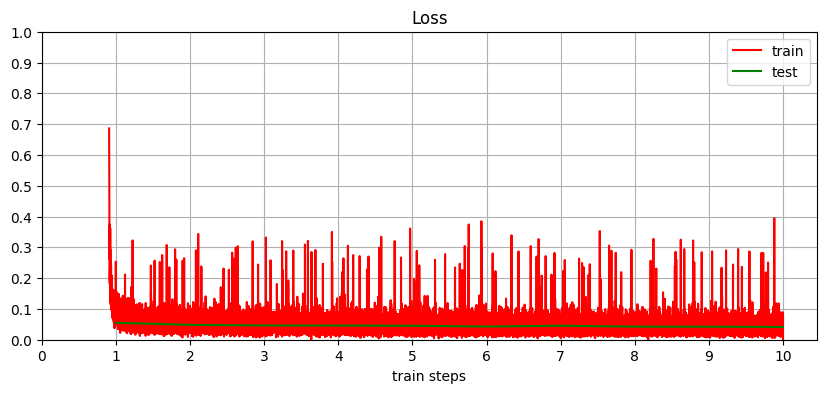

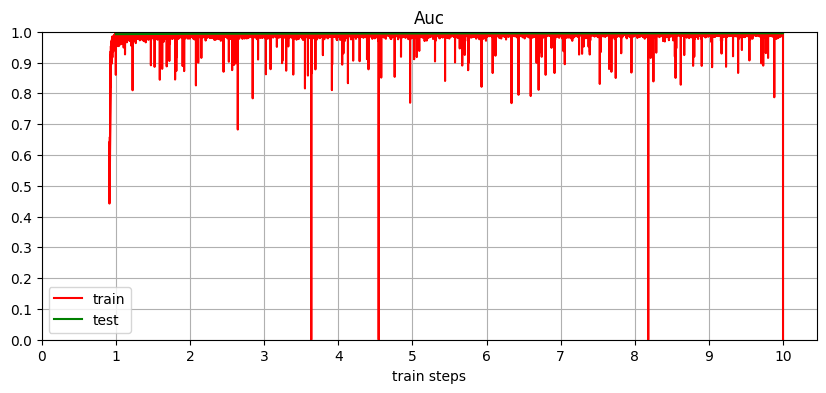

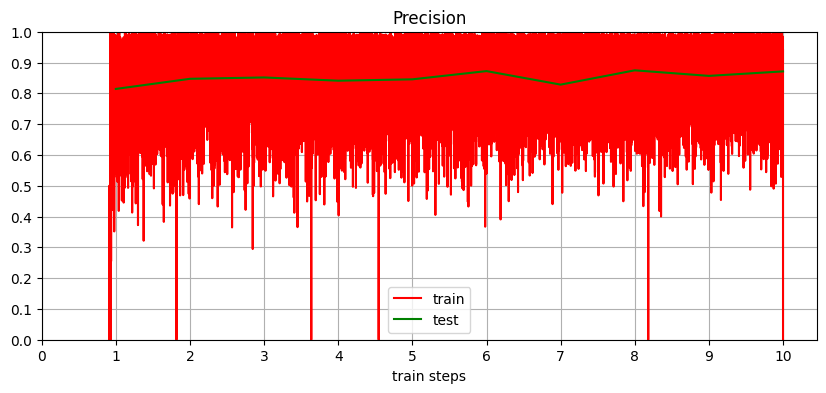

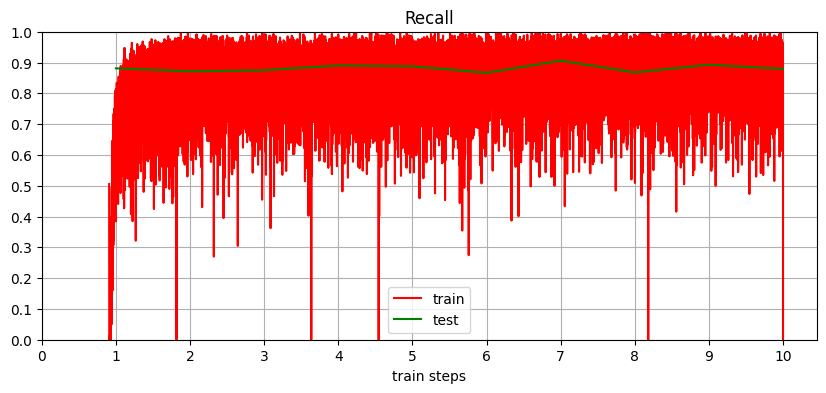

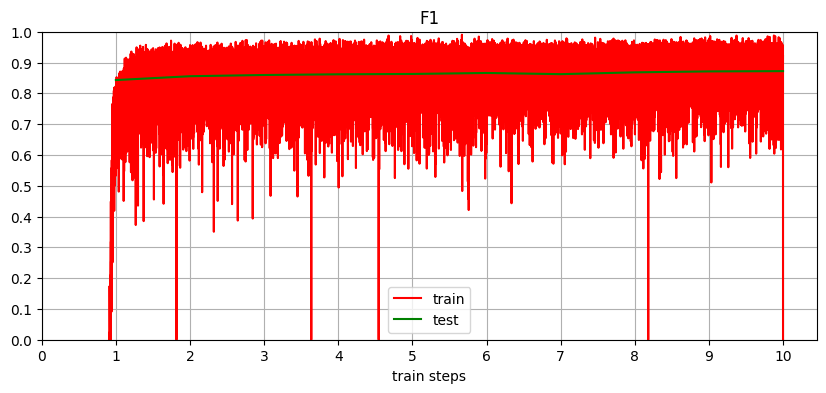

Time:  8.399270908037822
Epoch 10: ROC-AUC = 99.51%
Epoch 10: Precision = 0.871
Epoch 10: Recall = 0.879
Epoch 10: F1-score = 0.872
Final ROC-AUC = 0.9951
Final Precision = 0.871
Final Recall = 0.879
Final F1-score = 0.872
CPU times: user 1h 3min 6s, sys: 16min 59s, total: 1h 20min 5s
Wall time: 1h 24min 42s


In [27]:
%%time

feature_count = len(groups)
device = torch.device(f'cuda:{1}')
with torch.cuda.device(device):
    set_random_seed(42)
    model = DeepCNNSiLU_9L(feature_count)
    model = model.to('cuda')

    opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 10, loader_train, loader_test)
    

In [28]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}".format(val_f1_log[np.argmax(val_f1_log)]))
print("ROC-AUC: {:.4f}".format(val_auc_log[np.argmax(val_f1_log)]))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 10
Max F1-score: 0.8721
ROC-AUC: 0.9951
Precision: 0.8712
Recall: 0.8792
Mean time for 1 epoch 8.45 minutes


In [29]:
torch.save(model.state_dict(), 'DeepCNNSiLU_9L_1_4_k_mers.pt')

# Запуск 1-5-меры

In [30]:
params = {'batch_size':32,
          'num_workers':4,
          'shuffle':True}

max_k_mer_size = 5
groups = generate_subgroups(max_k_mer_size)

train_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, train_intervals, max_k_mer_size, groups, lrp_feat = [])

test_dataset = Dataset(chrom_names, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, test_intervals, max_k_mer_size, groups, lrp_feat = [])

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)

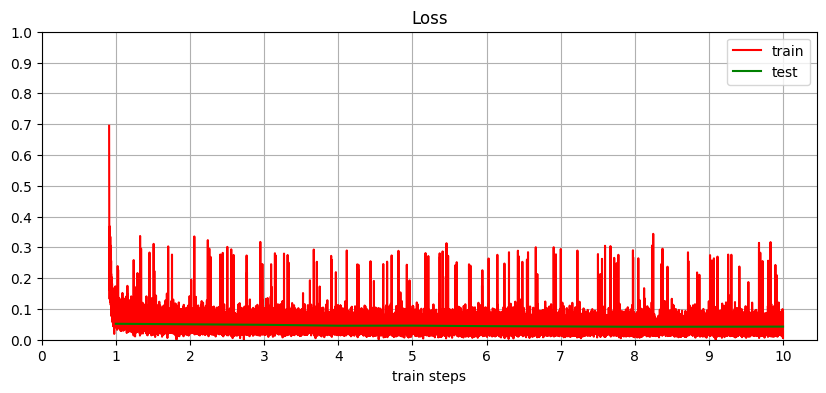

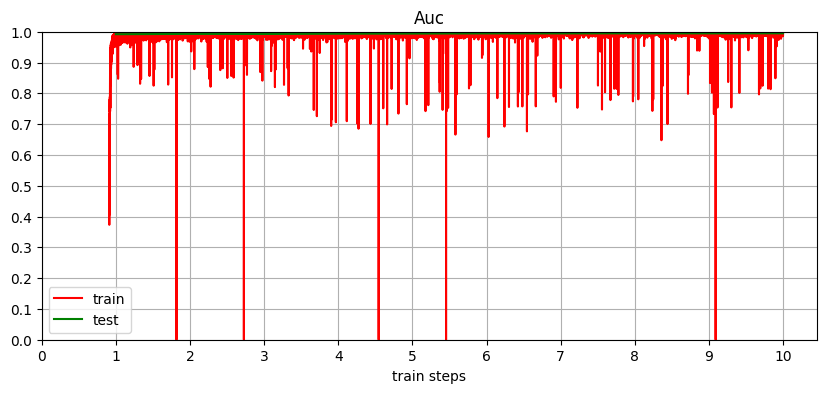

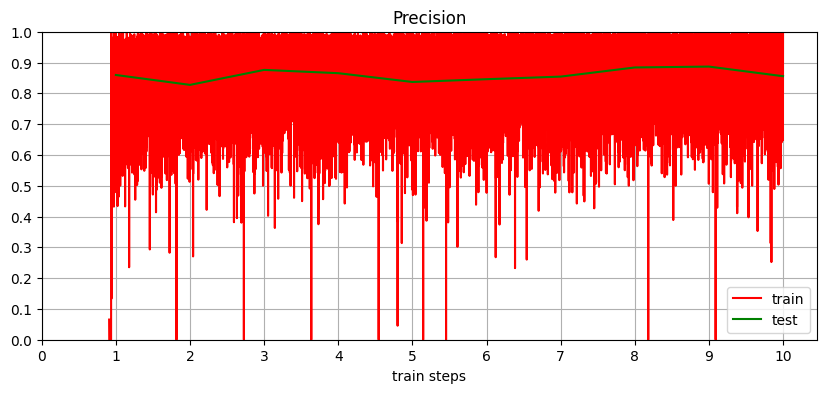

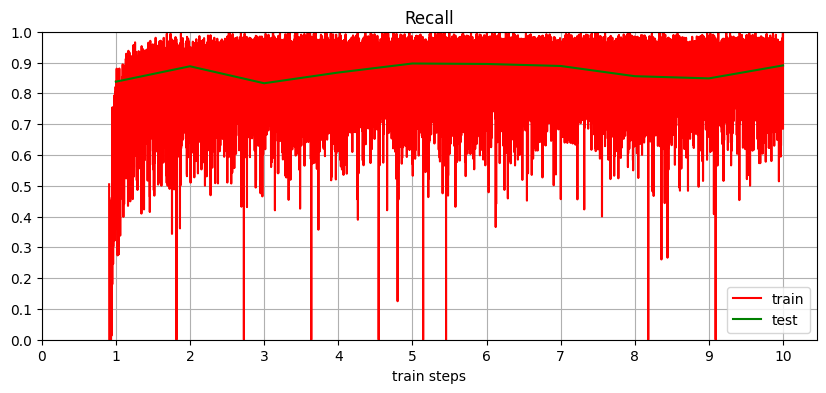

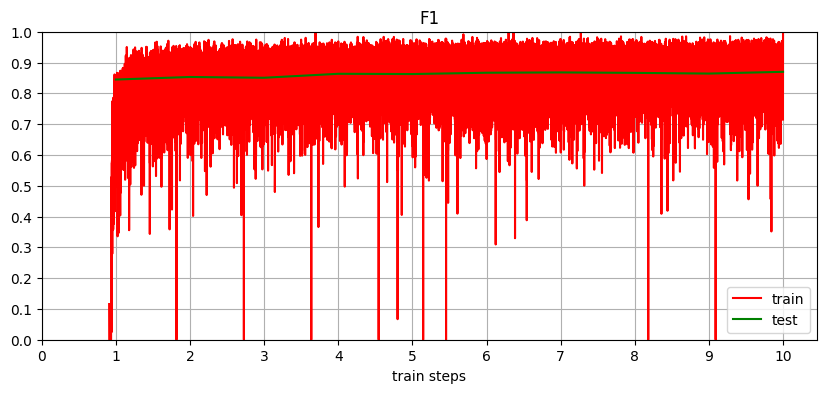

Time:  29.18672293027242
Epoch 10: ROC-AUC = 99.48%
Epoch 10: Precision = 0.856
Epoch 10: Recall = 0.891
Epoch 10: F1-score = 0.87
Final ROC-AUC = 0.9948
Final Precision = 0.856
Final Recall = 0.891
Final F1-score = 0.87
CPU times: user 3h 41min, sys: 1h 11min 1s, total: 4h 52min 1s
Wall time: 5h 18min 1s


In [31]:
%%time

feature_count = len(groups)
device = torch.device(f'cuda:{1}')
with torch.cuda.device(device):
    set_random_seed(42)
    model = DeepCNNSiLU_9L(feature_count)
    model = model.to('cuda')

    opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, 10, loader_train, loader_test)
    

In [32]:
print("Epoch {}".format(np.argmax(val_f1_log) + 1))
print("Max F1-score: {:.4f}".format(val_f1_log[np.argmax(val_f1_log)]))
print("ROC-AUC: {:.4f}".format(val_auc_log[np.argmax(val_f1_log)]))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 10
Max F1-score: 0.8698
ROC-AUC: 0.9948
Precision: 0.8556
Recall: 0.8906
Mean time for 1 epoch 31.78 minutes


In [33]:
torch.save(model.state_dict(), 'DeepCNNSiLU_9L_1_5_k_mers.pt')